In [2]:
import numpy as np
import pandas as pd
import openml
import pickle
import os
import sys
from meta_model.utils import ndcg_sim, ndcg, custom_sim
import matplotlib.pyplot as plt
sys.path.append("meta_model")

In [3]:
benchmark_results = {}
benchmark_results_dir = "meta_dataset_creation/data/benchmark_results/"
clustering_algorithms = os.listdir(benchmark_results_dir)
clustering_algorithms

['kprototypes', 'haverage', 'fasterpam']

In [31]:
for algorithm in clustering_algorithms:
    print(algorithm)
    benchmark_results[algorithm] = {}
    for name in os.listdir(os.path.join(benchmark_results_dir, algorithm)):
        print("\t", name)
        benchmark_results[algorithm][name] = {}
        folder_path = os.path.join(benchmark_results_dir, algorithm, name)
        scores_dir = os.path.join(folder_path, "scores/")
        for filename in os.listdir(scores_dir):
            data_id = filename.split('.')[0]
            with open(os.path.join(scores_dir, filename), "rb") as f:
                result = pickle.load(f)
            for sim_pair in result:
                for eval_metric in result[sim_pair]:
                    if eval_metric not in benchmark_results[algorithm][name]:
                        benchmark_results[algorithm][name][eval_metric] = {}
                    if data_id not in benchmark_results[algorithm][name][eval_metric]:
                        benchmark_results[algorithm][name][eval_metric][data_id] = {}
                    benchmark_results[algorithm][name][eval_metric][data_id][sim_pair] = \
                        max([v["score"] for v in result[sim_pair][eval_metric] \
                            if eval_metric != "sil" or 0.05 <= v["params"]["gamma" if algorithm=="kprototypes" else "alpha"] <= (20 if algorithm=="kprototypes" else 0.95)])
                    # if eval_metric == "sil":
                    #     print(sim_pair, sorted(result[sim_pair][eval_metric], reverse=True, key= lambda v: v["score"])[0])
        
        for eval_metric in benchmark_results[algorithm][name]:
            benchmark_results[algorithm][name][eval_metric] = \
                pd.DataFrame.from_dict(benchmark_results[algorithm][name][eval_metric], orient='index')
            benchmark_results[algorithm][name][eval_metric] = \
                benchmark_results[algorithm][name][eval_metric].fillna(-1)
            benchmark_results[algorithm][name][eval_metric] = \
                benchmark_results[algorithm][name][eval_metric].replace(-1, -10)
            print(eval_metric, benchmark_results[algorithm][name][eval_metric].shape)
        
        if len(benchmark_results[algorithm][name]) > 0:
            indices = np.random.permutation(benchmark_results[algorithm][name]["acc"].shape[0])
            for eval_metric in benchmark_results[algorithm][name]:
                benchmark_results[algorithm][name][eval_metric] = benchmark_results[algorithm][name][eval_metric].iloc[indices]
            
            max_ = benchmark_results[algorithm][name]["acc"].max(axis=1)
            for eval_metric in ["acc", "ari", "purity"]:
                # benchmark_results[algorithm][name][eval_metric] = benchmark_results[algorithm][name][eval_metric][max_ >= 0.8]
                print(eval_metric, benchmark_results[algorithm][name][eval_metric].shape)
            print()

kprototypes
	 from_numeric


In [ ]:
algorithm = 'kprototypes'
eval_metric = 'acc'
benchmark_results[algorithm]["original"][eval_metric].head()

,euclidean_hamming,euclidean_eskin,euclidean_iof,euclidean_of,euclidean_jaccard,euclidean_dice,euclidean_kulsinski,euclidean_rogerstanimoto,euclidean_russellrao,euclidean_sokalmichener,...,euclidean_co-oc,manhattan_co-oc,chebyshev_co-oc,sqeuclidean_co-oc,canberra_co-oc,mahalanobis_co-oc,cosine_co-oc,pearson_co-oc,lorentzian_co-oc,divergence_co-oc
42172,0.837838,0.859459,0.837838,0.854054,0.864865,0.864865,0.870270,0.848649,0.870270,0.848649,...,0.854054,0.789189,0.859459,0.859459,0.735135,0.864865,0.864865,0.843243,0.789189,0.762162
481,0.737113,0.737113,0.737113,0.737113,0.757732,0.757732,0.757732,0.757732,0.757732,0.757732,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
42585,0.889222,0.889222,0.889222,0.889222,0.889222,0.889222,0.889222,0.889222,0.889222,0.889222,...,0.889222,0.877246,0.922156,0.889222,0.844311,0.979042,0.982036,0.988024,0.838323,0.871257
854,0.924051,0.924051,0.924051,0.924051,0.924051,0.924051,0.924051,0.924051,0.924051,0.924051,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
339,0.777778,0.777778,0.777778,0.777778,0.666667,0.666667,0.666667,0.583333,0.666667,0.583333,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000


In [ ]:
dataset_statistics = ["n_instances", "n_features",
                      "dim", "num_on_cat", "n_num_att", "n_cat_att"]
attributes_statistics = [
    f"{p}_{name}" for p in ["min", "q1", "mean", "q3", "max"] for name in [
        "means_num_att", "std_num_att",  # "kurtosis_num_att", "skewness_num_att",
        "card_cat_att", "entropy_cat_att",
        "covariance",
    ]
]

isolation_forest = [f"isolation_forest_{i}" for i in range(10)]

proposed_attributes_statistics = [
    f"{p}_{name}" for p in ["min", "q1", "mean", "q3", "max"] for name in [
        # "kurtosis_squared_num_att", "skewness_squared_num_att",
        "means_squared_num_att", "std_squared_num_att",
        # "kurtosis_internal_product_num_att", "skewness_internal_product_num_att",
        "means_internal_product_num_att", "std_internal_product_num_att",
        "mutual_info_cat_att",
        "std_freq_cat_att"
    ]
]

In [ ]:
from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
mixed_meta_df = pd.read_csv("meta_dataset_creation/data/meta_features/original/meta_features.csv", index_col="id").drop_duplicates()
mixed_meta_df.index = mixed_meta_df.index.astype(str)
print("Number of meta features:", mixed_meta_df.shape[1])
print("Number of instances:", mixed_meta_df.shape[0])

Number of meta features: 61
Number of instances: 177


In [ ]:
numeric_meta_df = pd.read_csv("meta_dataset_creation/data/meta_features/from_numeric/meta_features.csv", index_col="id").drop_duplicates()
numeric_meta_df.index = numeric_meta_df.index.astype(str)
print("Number of meta features:", numeric_meta_df.shape[1])
print("Number of instances:", numeric_meta_df.shape[0])

Number of meta features: 61
Number of instances: 500


In [ ]:
from sklearn.metrics import pairwise_distances
index = benchmark_results[algorithm]["original"][eval_metric].index
mixed_Y = benchmark_results[algorithm]["original"][eval_metric][index.isin(mixed_meta_df.index)].to_numpy()
mixed_Yn = np.array([y/max(y) for y in mixed_Y])
mixed_Yn[mixed_Yn>0] **= 4
mixed_Yn[mixed_Yn<0] = -1

# index = benchmark_results[algorithm]["from_numeric"][eval_metric].index
# numeric_Y = benchmark_results[algorithm]["from_numeric"][eval_metric][index.isin(numeric_meta_df.index)].to_numpy()
# numeric_Yn = np.array([y/max(y) for y in numeric_Y])
# numeric_Yn[numeric_Yn>0] **= 4
# numeric_Yn[numeric_Yn<0] = -1

In [ ]:
index = benchmark_results[algorithm]["original"][eval_metric].index
mixed_X = mixed_meta_df.loc[[i for i in index if i in mixed_meta_df.index]].to_numpy()

# index = benchmark_results[algorithm]["from_numeric"][eval_metric].index
# numeric_X = numeric_meta_df.loc[[i for i in index if i in numeric_meta_df.index]].to_numpy()
sc = StandardScaler().fit(mixed_X) # StandardScaler().fit(np.concatenate((mixed_X, numeric_X))) #
mixed_X = sc.transform(mixed_X) # mixed_X/mixed_X.shape[1] #
# numeric_X = sc.transform(numeric_X) # numeric_X/numeric_X.shape[1] #

mixed_X.shape #, numeric_X.shape

(53, 61)

In [ ]:
X = mixed_X # np.concatenate((mixed_X, numeric_X))
X2 = X[:, [i for i in range(X.shape[1]) if mixed_meta_df.columns.values[i] in dataset_statistics+attributes_statistics]]
Y = mixed_Y # np.concatenate((mixed_Y, numeric_Y))
Yn = mixed_Yn # np.concatenate((mixed_Yn, numeric_Yn))

In [ ]:
selected_datasets = np.array([i for i in range(mixed_X.shape[0])])
print(len(selected_datasets))

53


In [ ]:
from sklearn.model_selection import cross_val_score
from meta_model.ranking import ALL_MODELS
from sklearn.metrics import make_scorer
from meta_model.ranking import scorer
import pygad

# scorer = make_scorer(lambda yt, yp: np.mean([y[y>0][np.argmax(yp[i][y>0])] for i, y in enumerate(yt)]))
# scorer = make_scorer(lambda yt, yp: np.mean(ndcg(yt, yp, p=5)))

metrics = ["euclidean", "manhattan", "cosine"]
weights = ["uniform", "distance"]

def on_generation(ga_instance):
    _, fitness, _ = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)
    print(f"GEN: {ga_instance.generations_completed}, Best fitness: {fitness}")

def fitness_func(ga_instance, solution, solution_idx):
    selected_feats = np.array(solution[:X.shape[1]])>0
    n_neighbors = solution[X.shape[1]]
    metric = metrics[solution[X.shape[1]+1]]
    w = weights[solution[X.shape[1]+2]]
    knn = ALL_MODELS["KNN"](n_neighbors=n_neighbors, metric=metric, weights=w)
    fitness = np.mean(cross_val_score(knn, X[selected_datasets][:, selected_feats], Y[selected_datasets], cv=10, scoring=scorer, n_jobs=-1))
    return fitness - 1e-5*sum(selected_feats)

fitness_function = fitness_func

num_generations = 100
num_parents_mating = 20

sol_per_pop = 40
num_genes = X.shape[1] + 3
gene_type = int
gene_space = [[0, 1] for _ in range(X.shape[1])] + [range(1, 31), range(3), [0, 1]]

parent_selection_type = "sss"
keep_elitism = 1
crossover_type = "uniform"
crossover_probability = 0.9
mutation_type = "random"
mutation_probability = 0.1

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       gene_type=gene_type,
                       gene_space=gene_space,
                       parent_selection_type=parent_selection_type,
                       keep_elitism=keep_elitism,
                       crossover_type=crossover_type,
                       crossover_probability=crossover_probability,
                       mutation_type=mutation_type,
                       mutation_probability=mutation_probability,
                       on_generation=on_generation,
                    #    parallel_processing=['process', 32],
                    #    save_best_solutions=True
                    )
ga_instance.run()

GEN: 1, Best fitness: 0.8062127439999739
GEN: 2, Best fitness: 0.809197348042496
GEN: 3, Best fitness: 0.809197348042496
GEN: 4, Best fitness: 0.809197348042496
GEN: 5, Best fitness: 0.809197348042496
GEN: 6, Best fitness: 0.809197348042496
GEN: 7, Best fitness: 0.809197348042496
GEN: 8, Best fitness: 0.809197348042496
GEN: 9, Best fitness: 0.809197348042496
GEN: 10, Best fitness: 0.809197348042496
GEN: 11, Best fitness: 0.809197348042496
GEN: 12, Best fitness: 0.809197348042496
GEN: 13, Best fitness: 0.809197348042496
GEN: 14, Best fitness: 0.809197348042496
GEN: 15, Best fitness: 0.809197348042496
GEN: 16, Best fitness: 0.809197348042496
GEN: 17, Best fitness: 0.809197348042496
GEN: 18, Best fitness: 0.809197348042496
GEN: 19, Best fitness: 0.809197348042496
GEN: 20, Best fitness: 0.81008059123259
GEN: 21, Best fitness: 0.81008059123259
GEN: 22, Best fitness: 0.8111745361946385
GEN: 23, Best fitness: 0.8111745361946385
GEN: 24, Best fitness: 0.8111745361946385
GEN: 25, Best fitness: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


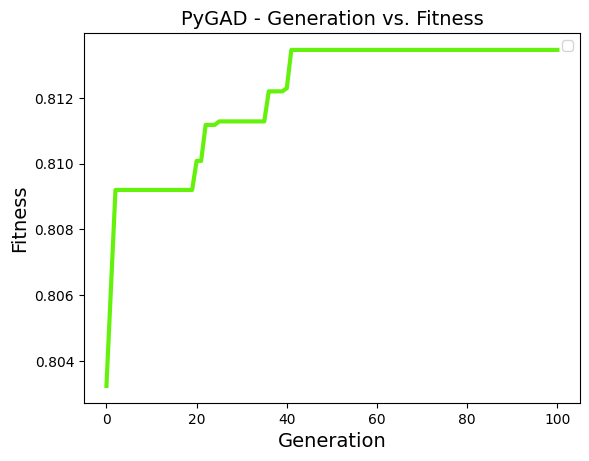

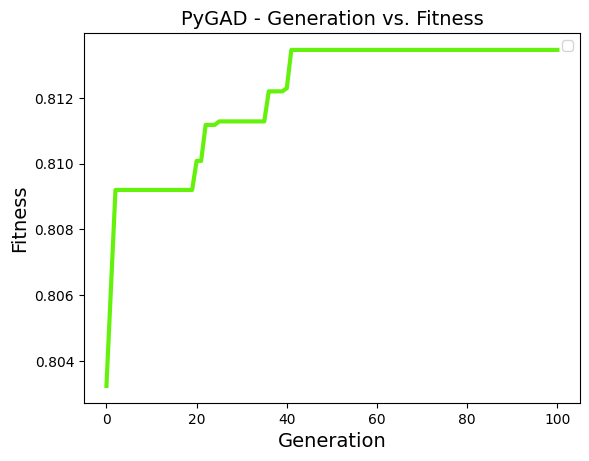

In [ ]:
ga_instance.plot_fitness()

In [ ]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
selected_features = np.array(solution[:X.shape[1]])>0
print(sum(selected_features))
mixed_meta_df.columns[selected_features]

27


Index(['n_instances', 'dim', 'n_num_att', 'min_means_num_att',
       'q3_means_num_att', 'max_means_num_att', 'min_std_num_att',
       'q3_std_num_att', 'min_means_squared_num_att',
       'q3_means_squared_num_att', 'q1_means_internal_product_num_att',
       'max_means_internal_product_num_att',
       'mean_std_internal_product_num_att', 'min_covariance',
       'mean_covariance', 'q3_covariance', 'n_cat_att', 'mean_card_cat_att',
       'q3_card_cat_att', 'max_card_cat_att', 'q1_entropy_cat_att',
       'mean_entropy_cat_att', 'max_entropy_cat_att', 'q1_mutual_info_cat_att',
       'max_mutual_info_cat_att', 'min_std_freq_cat_att',
       'mean_std_freq_cat_att'],
      dtype='object')

In [ ]:
# sim_pair = np.argmax(mixed_Y[0]) #sim_pairs_index["manhattan_hamming"]
# features = [i for i, v in enumerate(selected_features) if v]
# n_rows = len(features)
# n_cols = len(features)
# plt.figure(figsize=(2*n_cols, 2*n_rows))
# for i in range(n_rows - 1):
#     for j in range(i+1, n_cols):
#         plt.subplot(n_rows, n_cols, i*n_cols + j + 1)
#         plt.scatter(mixed_X[:,features[i]], mixed_X[:,features[j]], c=Y[:mixed_X.shape[0], sim_pair], cmap="YlOrRd")
#         # plt.scatter(mixed_X[:,features[i]], mixed_X[:,features[j]], c=sim_matrix[0, :mixed_X.shape[0]], cmap="YlOrRd", vmin=0.5, vmax=1)
#         plt.xticks([])
#         plt.yticks([])
# plt.tight_layout(h_pad=0, w_pad=0)
# plt.show()

In [ ]:
# # Scale the dataset; This is very important before you apply PCA
# #
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# #
# # Instantiate PCA
# #
# pca = PCA()
# #
# # Determine transformed features
# #
# X_pca = pca.fit_transform(mixed_X)
# #
# # Determine explained variance using explained_variance_ration_ attribute
# #
# exp_var_pca = pca.explained_variance_ratio_
# #
# # Cumulative sum of eigenvalues; This will be used to create step plot
# # for visualizing the variance explained by each principal component.
# #
# cum_sum_eigenvalues = np.cumsum(exp_var_pca)
# #
# # Create the visualization plot
# #
# plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
# plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
# plt.ylabel('Explained variance ratio')
# plt.xlabel('Principal component index')
# plt.legend(loc='best')
# plt.tight_layout()
# plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
from meta_model.ranking import ALL_MODELS
from sklearn.metrics import make_scorer
from meta_model.ranking import scorer
import pygad

# scorer = make_scorer(lambda yt, yp: np.mean([(y[y>0][np.argmax(yp[i][y>0])]) for i, y in enumerate(yt)]))
# scorer = make_scorer(lambda yt, yp: np.mean(ndcg(yt, yp, p=5)))

metrics = ["euclidean", "manhattan", "cosine"]
weights = ["uniform", "distance"]

def on_generation(ga_instance):
    _, fitness, _ = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)
    print(f"GEN: {ga_instance.generations_completed}, Best fitness: {fitness}")
    
def fitness_func(ga_instance, solution, solution_idx):
    selected_feats = np.array(solution[:X2.shape[1]])>0
    n_neighbors = solution[X2.shape[1]]
    metric = metrics[solution[X2.shape[1]+1]]
    w = weights[solution[X2.shape[1]+2]]
    knn = ALL_MODELS["KNN"](n_neighbors=n_neighbors, metric=metric, weights=w)
    fitness = np.mean(cross_val_score(knn, X2[selected_datasets][:, selected_feats], Y[selected_datasets], cv=10, scoring=scorer, n_jobs=-1))
    return fitness - 1e-5*sum(selected_feats)

fitness_function = fitness_func

num_generations = 100
num_parents_mating = 20

sol_per_pop = 40
num_genes = X2.shape[1] + 3
gene_type = int
gene_space = [[0, 1] for _ in range(X2.shape[1])] + [range(1, 31), range(3), [0, 1]]

parent_selection_type = "sss"
keep_elitism = 1
crossover_type = "uniform"
crossover_probability = 0.9
mutation_type = "random"
mutation_probability = 0.1

ga_instance2 = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       gene_type=gene_type,
                       gene_space=gene_space,
                       parent_selection_type=parent_selection_type,
                       keep_elitism=keep_elitism,
                       crossover_type=crossover_type,
                       crossover_probability=crossover_probability,
                       mutation_type=mutation_type,
                       mutation_probability=mutation_probability,
                       on_generation=on_generation,
                    #    parallel_processing=['process', 16],
                    #    save_best_solutions=True
                    )
ga_instance2.run()

GEN: 1, Best fitness: 0.806608516146328
GEN: 2, Best fitness: 0.8070486730406843
GEN: 3, Best fitness: 0.8088513341604872
GEN: 4, Best fitness: 0.8088513341604872
GEN: 5, Best fitness: 0.8088513341604872
GEN: 6, Best fitness: 0.8092600404416255
GEN: 7, Best fitness: 0.8092600404416255
GEN: 8, Best fitness: 0.8092600404416255
GEN: 9, Best fitness: 0.8092600404416255
GEN: 10, Best fitness: 0.8100799111554917
GEN: 11, Best fitness: 0.8100799111554917
GEN: 12, Best fitness: 0.8100799111554917
GEN: 13, Best fitness: 0.8100799111554917
GEN: 14, Best fitness: 0.8100799111554917
GEN: 15, Best fitness: 0.811137014485457
GEN: 16, Best fitness: 0.811137014485457
GEN: 17, Best fitness: 0.811137014485457
GEN: 18, Best fitness: 0.811137014485457
GEN: 19, Best fitness: 0.811137014485457
GEN: 20, Best fitness: 0.811137014485457
GEN: 21, Best fitness: 0.811137014485457
GEN: 22, Best fitness: 0.811137014485457
GEN: 23, Best fitness: 0.811137014485457
GEN: 24, Best fitness: 0.811137014485457
GEN: 25, Bes

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


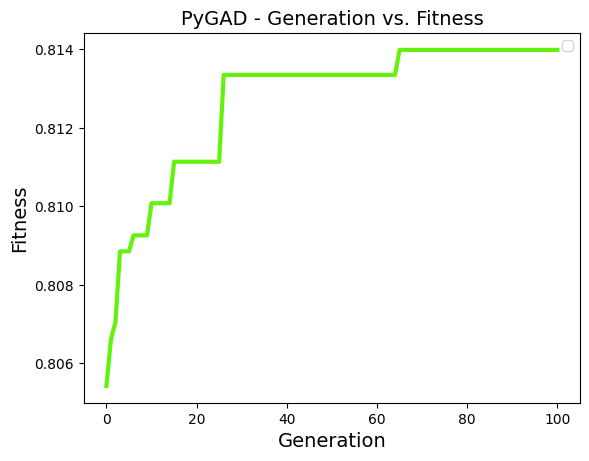

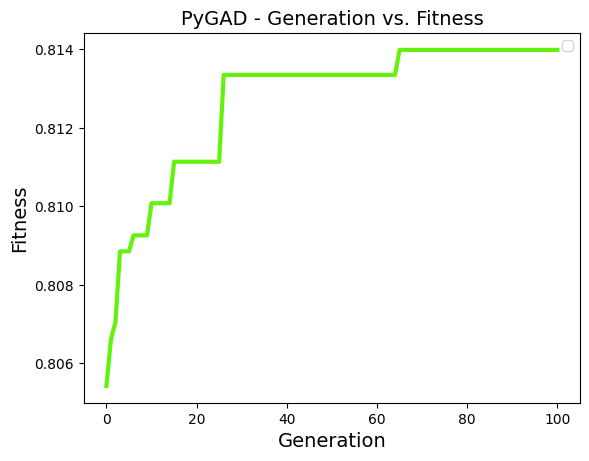

In [ ]:
ga_instance2.plot_fitness()

In [ ]:
solution2, solution_fitness2, solution_idx2 = ga_instance2.best_solution()
selected_features2 = np.array(solution2[:X2.shape[1]])>0
print(sum(selected_features2))

17


In [ ]:
from meta_model.utils import ndcg
from meta_model.ranking import ALL_MODELS
from meta_model.ranking_tree import RankingTree
from sklearn.model_selection import KFold, cross_val_predict

models = {
    "KNN": ALL_MODELS["KNN"](),
    "KNN-FS": ALL_MODELS["KNN"](),
    "KNN-AMF": ALL_MODELS["KNN"](),
    "KNN-AMF-FS": ALL_MODELS["KNN"](),
    # "RT": ALL_MODELS["RT"](min_samples_split=3),
}
n_splits=10
predictions = {model_name: np.zeros(shape=(len(selected_datasets), 120)) for model_name in models}
predictions["AR"] = np.zeros(shape=(len(selected_datasets), 120))

models["KNN"] = models["KNN"].cross_val_fit(X2[selected_datasets], Y[selected_datasets], n_splits=n_splits) #
predictions["KNN"] = cross_val_predict(models["KNN"], X2[selected_datasets], Y[selected_datasets], cv=n_splits)

n_neighbors = solution2[X2.shape[1]]
metric = metrics[solution2[X2.shape[1]+1]]
w = weights[solution2[X2.shape[1]+2]]
knn = ALL_MODELS["KNN"](n_neighbors=n_neighbors, metric=metric, weights=w)
predictions["KNN-FS"] = cross_val_predict(knn, X2[selected_datasets][:, selected_features2], Y[selected_datasets], cv=n_splits)

models["KNN-AMF"] = models["KNN-AMF"].cross_val_fit(X[selected_datasets], Y[selected_datasets], n_splits=n_splits) #
predictions["KNN-AMF"] = cross_val_predict(models["KNN-AMF"], X[selected_datasets], Y[selected_datasets], cv=n_splits)

n_neighbors = solution[X.shape[1]]
metric = metrics[solution[X.shape[1]+1]]
w = weights[solution[X.shape[1]+2]]
knn = ALL_MODELS["KNN"](n_neighbors=n_neighbors, metric=metric, weights=w)
predictions["KNN-AMF-FS"] = cross_val_predict(knn, X[selected_datasets][:, selected_features], Y[selected_datasets], cv=n_splits)

for train, test in KFold(n_splits=n_splits).split(X[selected_datasets]):
    predictions["AR"][test] = np.array([
        [np.mean([v for v in Y[train, j]]) for j in range(Y.shape[1])]
        for _ in test
    ])

In [ ]:
baseline_pairs = {
    "haverage": "manhattan_hamming",
    "fasterpam": "euclidean_hamming",
    "kprototypes": "sqeuclidean_hamming",
}
similarity_pairs = benchmark_results[algorithm]["original"][eval_metric].columns
sim_pairs_index = dict(zip(similarity_pairs, range(len(similarity_pairs))))

ndcg_ranks = [1, 3, 5, 10, 15, 20]
n_bests = [1, 3, 5, 10]
ndcg_scores = {
    model_name: {p: np.zeros(len(selected_datasets)) for p in ndcg_ranks}
    for model_name in predictions
} #| {'ensemble': {p: np.zeros(meta_X.shape[0]) for p in ndcg_ranks}}

lb_scores = np.zeros(len(selected_datasets))
rb_scores = {k: np.zeros(len(selected_datasets)) for k in n_bests}
mb_scores = np.zeros(len(selected_datasets))
model_scores = {
    model_name: {k: np.zeros(len(selected_datasets)) for k in n_bests}
    for model_name in predictions
} #| {'ensemble': {k: np.zeros(len(test_index)) for k in n_bests}}

for name, Y_pred in predictions.items():
    Y_pred = np.array(Y_pred)
    for p in ndcg_ranks:
        ndcg_scores[name][p] = ndcg(Yn[selected_datasets], Y_pred, p=p)

for name, Y_pred in predictions.items():
    Y_pred = np.array(Y_pred)
    for k in n_bests:
        model_scores[name][k] = np.array(
            [max(y[y > 0][np.argsort(-Y_pred[i][y > 0])[:k]]) for i, y in enumerate(Y[selected_datasets])])

for k in n_bests:
    rb_scores[k] = np.array(
        [max(np.random.choice(y[y > 0], k)) for y in Y[selected_datasets]])

lb_scores = Y[selected_datasets][:, sim_pairs_index[baseline_pairs[algorithm]]]
mb_scores = np.array([max(y) for y in Y[selected_datasets]])

/homedir/adiop/workspace/simrec-for-mdc/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homedir/adiop/workspace/simrec-for-mdc/venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


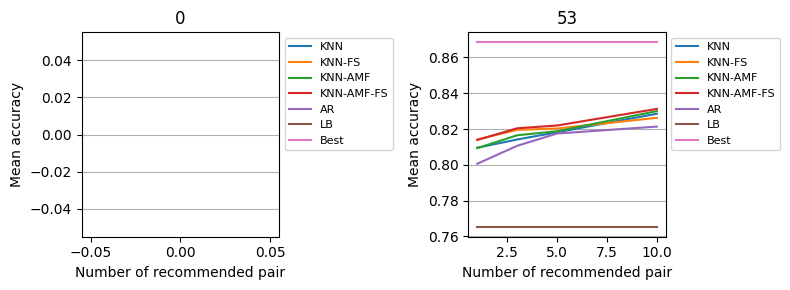

In [ ]:
import matplotlib.pyplot as plt

list_indices = [
    [i for i, y in enumerate(Y[selected_datasets]) if np.mean(1 - y[y>0]/max(y[y>0])) < 0.0], #test_index[i] in base_datasets and # i in test and
    [i for i, y in enumerate(Y[selected_datasets]) if np.mean(1 - y[y>0]/max(y[y>0])) >= 0.]
]
rows, cols = 1, len(list_indices)
plt.figure(figsize=(cols*4, rows*3))
subplot_num = 1
exclude = [] #"KNN with aug.", "RF with aug." - "KNN", "RF", "AE+KNN", "AE+RF"
for indices in list_indices:
    scores = {k:v for k, v in model_scores.items() if k not in exclude} 
    # scores["RB"] = rb_scores
    scores["LB"] = lb_scores
    scores["Best"] = mb_scores

    y = {key: [] for key in scores}

    for name, score in scores.items():
        for k in n_bests:
            u = score[indices] if name in ["LB", "Best"] else score[k][indices]
            y[name].append(np.mean(u))

    plt.subplot(rows, cols, subplot_num)
    for name, values in y.items():
        plt.plot(n_bests, values, label=name)
    plt.ylabel("Mean accuracy")
    plt.xlabel("Number of recommended pair")
    # plt.ylim((0.67, 0.9))
    plt.legend(fontsize=8, loc= "upper left", bbox_to_anchor= (1, 1))
    plt.grid(axis="y")
    plt.title(len(indices))
    subplot_num += 1
plt.tight_layout()
# plt.savefig("output/mean_acc2.svg")
plt.show()

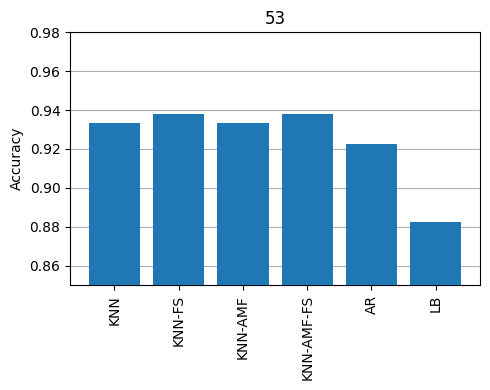

In [ ]:
import matplotlib.pyplot as plt

indices = [i for i, y in enumerate(Y[selected_datasets]) if np.mean(1 - y[y>0]/max(y[y>0])) >= 0]

exclude = []
scores = {k:v for k, v in model_scores.items() if k not in exclude} 
# scores["RB"] = rb_scores
scores["LB"] = lb_scores

y = {key: [] for key in scores}
k = 1
best_scores = mb_scores[indices]
for name, score in scores.items():
    u = score[indices] if name in ["LB", "Best"] else score[k][indices]
    y[name] = np.mean(u/best_scores)

plt.figure(figsize=(5, 4))
plt.bar(y.keys(), y.values(), zorder=5)
plt.ylabel("Accuracy")
plt.ylim((0.85, 0.98))
plt.xticks(rotation="vertical")
# plt.legend(fontsize=8, loc= "upper left", bbox_to_anchor= (1, 1))
plt.grid(axis="y")
plt.title(len(indices))
plt.tight_layout()
# plt.savefig("output/mean_acc2.svg")
plt.show()

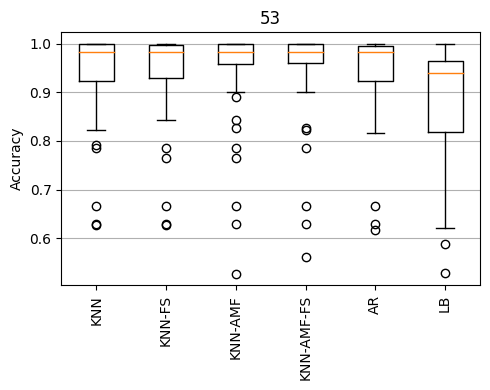

In [ ]:
import matplotlib.pyplot as plt

indices = [i for i, y in enumerate(Y[selected_datasets]) if np.mean(1 - y[y>0]/max(y[y>0])) >= 0.]

exclude = []
scores = {k:v for k, v in model_scores.items() if k not in exclude} 
# scores["RB"] = rb_scores
scores["LB"] = lb_scores

y = {key: [] for key in scores}
k = 5
best_scores = mb_scores[indices]
for name, score in scores.items():
    u = score[indices] if name in ["LB", "Best"] else score[k][indices]
    y[name] = u/best_scores

plt.figure(figsize=(5, 4))
plt.boxplot(y.values(), labels=y.keys())
plt.ylabel("Accuracy")
# plt.ylim((0.67, 0.9))
plt.xticks(rotation="vertical")
# plt.legend(fontsize=8, loc= "upper left", bbox_to_anchor= (1, 1))
plt.grid(axis="y")
plt.title(len(indices))
plt.tight_layout()
# plt.savefig("output/mean_acc2.svg")
plt.show()

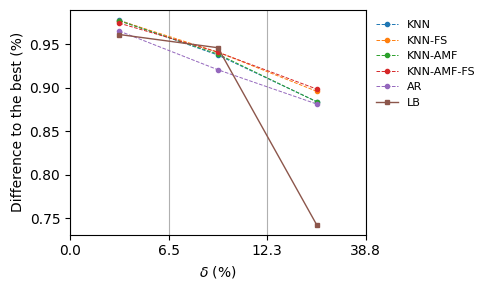

In [ ]:
baselines = ["LB"]
k = 1
plt.figure(figsize=(5, 3))
# if j == 0:
#     ax = plt.subplot(2, 1, 1)
# else:
#     ax = plt.subplot(2, 1, 2)
# res = results[algo]

best_scores = mb_scores
y = {}
l = [np.mean(1 - y[y>0]/max(y)) for i, y in enumerate(Y[selected_datasets])]
x = np.array([np.quantile(l, q) for q in np.linspace(0, 1, 4)])

x[0] -= 1e-4
diff = 0.025
list_indices = [
    [xr < np.mean(1 - y[y>0]/max(y)) <= x[r+1] for i, y in enumerate(Y[selected_datasets])]
    for r, xr in enumerate(x[:-1])
] #

for model_name, scores in model_scores.items():
    y[model_name] = []
    for i, indices in enumerate(list_indices):
        # new_ind = [val and lb_scores[j] >, 0, for j, val in enumerate(indices)]
        v = np.mean(((scores[k])/best_scores)[indices])
        y[model_name].append(v)

y["LB"] = []
for i, indices in enumerate(list_indices):
    v = np.mean(((lb_scores)/best_scores)[indices])
    y["LB"].append(v)

n_bar = len(y)
w = 0.8/n_bar
z = np.arange(len(x))
i = 0
max_ = np.zeros(len(list_indices))
min_ = np.ones(len(list_indices))*100
for model_name, values in y.items():
    max_ = np.maximum(max_, values)
    min_ = np.minimum(min_, values)
    # plt.plot(z[:-1]+0.5, values, "--", linewidth=0.7, label=None, alpha=1 if i<6 else 0.7, zorder=10)
    # plt.scatter(z[:-1]+0.5, values, label=model_name, s=[10*np.log(sum(val)) for val in list_indices], alpha=1 if i<6 else 0.7, zorder=10)
    plt.plot(z[:-1]+0.5, values, "--o" if model_name not in baselines else "-s", linewidth=0.7 if model_name not in baselines else 1, label=model_name, markersize=3, zorder=10)
    i += 1

for ind, val in enumerate(list_indices):
    if ind >= 1:
        plt.annotate(f"{max_[ind]:.2g}%", (z[ind]+0.5, max_[ind]+1), fontsize=8, ha="center", va="top")

# plt.bar(x[1:]-diff/2, [50 for _ in diff], width=diff[0], zorder=0, label=None, color="None", edgecolor="gray")

plt.xlim((z[0], z[-1]))
plt.ylabel("Difference to the best (%)")
plt.xticks(z, [f"{max(0, val*100):.1f}" for val in x])
# plt.ylim((min(min_)-1, max(max_)+1))
plt.grid(axis="x")
plt.legend(fontsize=8, loc= "upper left", bbox_to_anchor= (1, 1), frameon=False)
plt.xlabel("$\delta$ (%)")

# if j == 0:
#     plt.legend(fontsize=8, loc= "upper left", bbox_to_anchor= (1, 1), frameon=False)
# if j == 1: 
#     plt.xlabel("$\delta$ (%)")
# j += 1
# plt.title(names[algo], y=0.83)

plt.tight_layout()
# if savedir is not None:
#     plt.savefig(os.path.join(savedir, f"diff_best_delta_{algo}_{k}.pdf"))
plt.show()

In [ ]:
from scipy.stats import wilcoxon

model_names = ["KNN", "KNN-AMF-FS"]
baselines = ["LB", "RB", "ARB"]
y = {k:{} for k in model_names}
y_ndcg = {k:{} for k in model_names}

for model_name in model_names:
    scores = model_scores[model_name][1]
    baseline_scores = model_scores["AR"][1]
    s, p = wilcoxon(scores, baseline_scores, alternative="greater")
    y[model_name]["(top-1) ARB"] = f"{p:.3f}"

    baseline_scores = ndcg_scores["AR"][10]
    scores = ndcg_scores[model_name][10]
    s, p = wilcoxon(scores, baseline_scores, alternative="greater")
    y[model_name]["(NDCG) ARB"] = f"{p:.3f}"

print(pd.DataFrame.from_dict(y, orient='index'))

           (top-1) ARB (NDCG) ARB
KNN              0.089      0.628
KNN-AMF-FS       0.062      0.274


In [ ]:
# Save results

